In [46]:
### Importing necessary libraries
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir=r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\archive (3)\dataset\train'
test_dir=r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\archive (3)\dataset\test'

for d in [train_dir, test_dir]:
    filepaths = []
    labels=[] 
    classlist=sorted(os.listdir(d))
    
    for klass in classlist:
        label=klass.split('__')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)            
            labels.append(label)
    
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)

train_df, test_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])

print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  test_df length: ', len(test_df))

train_df lenght:  63265   test_df length:  7030   test_df length:  7030


In [3]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

The number of classes in the dataset is:  21
            CLASS               IMAGE COUNT 
         _Apple_scab               1814     
       _Bacterial_spot             4908     
          _Black_rot               3487     
      _Cedar_apple_rust            1584     
_Cercospora_leaf_spot Gray_leaf_spot     1478     
        _Common_rust_              1716     
        _Early_blight              3473     
    _Esca_(Black_Measles)          1728     
_Haunglongbing_(Citrus_greening)     1809     
         _Late_blight              3411     
          _Leaf_Mold               1694     
_Leaf_blight_(Isariopsis_Leaf_Spot)     1550     
         _Leaf_scorch              1597     
    _Northern_Leaf_Blight          1717     
       _Powdery_mildew             3077     
     _Septoria_leaf_spot           1571     
_Spider_mites Two-spotted_spider_mite     1567     
         _Target_Spot              1644     
_Tomato_Yellow_Leaf_Curl_Virus     1765     
     _Tomato_mosaic_virus          

### Create the train_gen, test_gen

In [4]:
# get the classes with the minimum and maximum number of train images
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

_healthy  has the most images=  20064   _Cercospora_leaf_spot Gray_leaf_spot  has the least images=  1478


In [5]:
# lets get the average height and width of a sample of the train images
ht=0
wt=0

# select 100 random samples of train_df
train_df_sample = train_df.sample(n= 100, random_state= 123, axis= 0)

for i in range(len(train_df_sample)):
    
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    
    ht += shape[0]
    wt += shape[1]

print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

average height=  256  average width=  256 aspect ratio=  1.0


In [6]:
train_gen = ImageDataGenerator(rescale=None, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=None, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = train_gen.flow_from_directory(train_dir, target_size=(128,128), batch_size=32, class_mode='categorical')

test_set=test_gen.flow_from_directory(test_dir, target_size=(128,128), batch_size=32, class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [7]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen) # get a sample batch from the generator 
    
    plt.figure(figsize=(20, 20))
    
    length=len(labels)
    
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        
        index=np.argmax(labels[i])
        class_name=classes[index]
        
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
        
    plt.show()

Images for Training......................


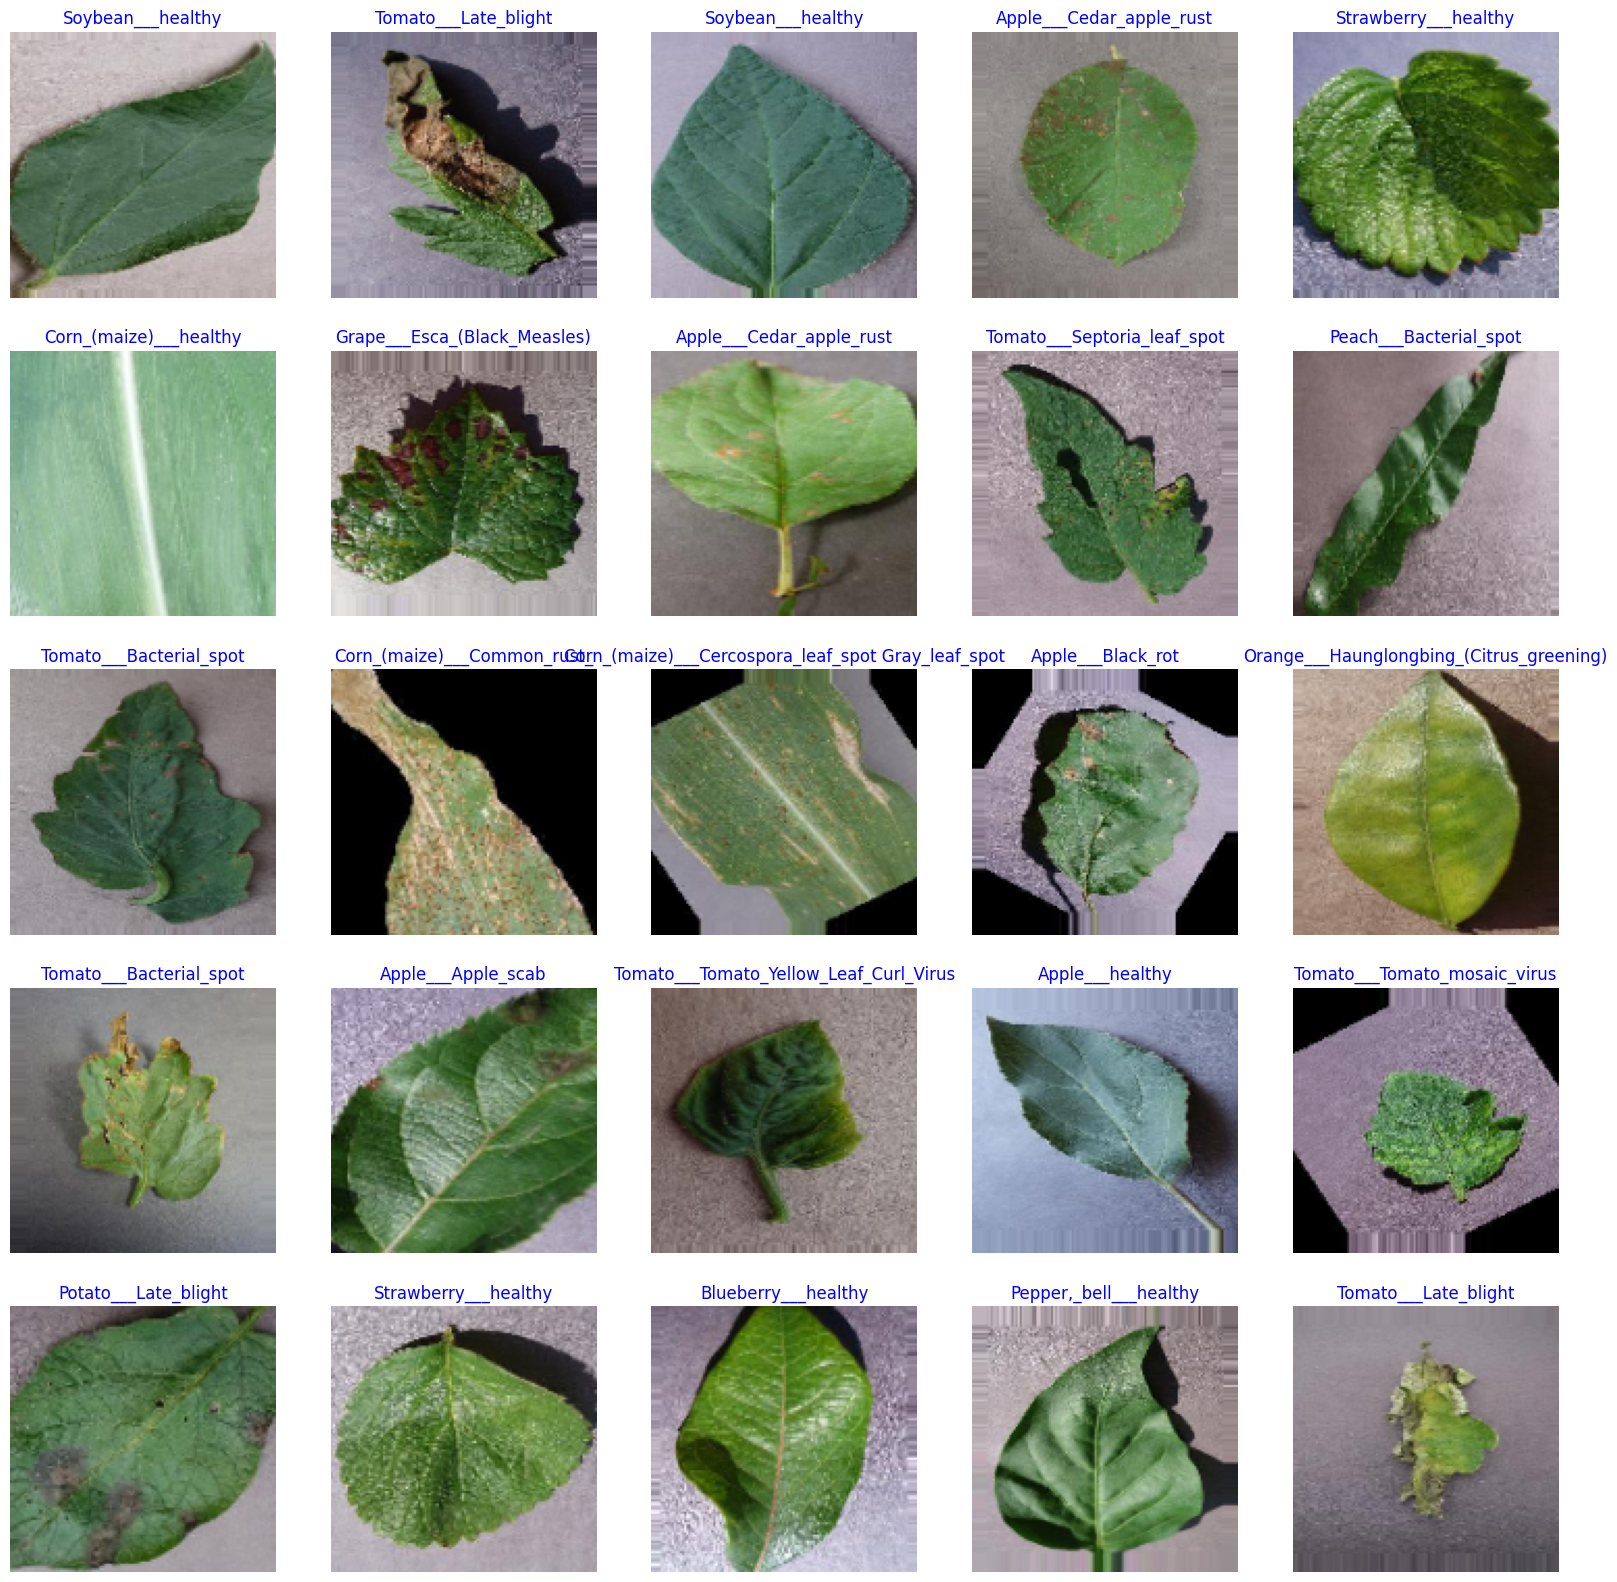

In [8]:
print("Images for Training......................")
show_image_samples(training_set )

Images for Testing.......................


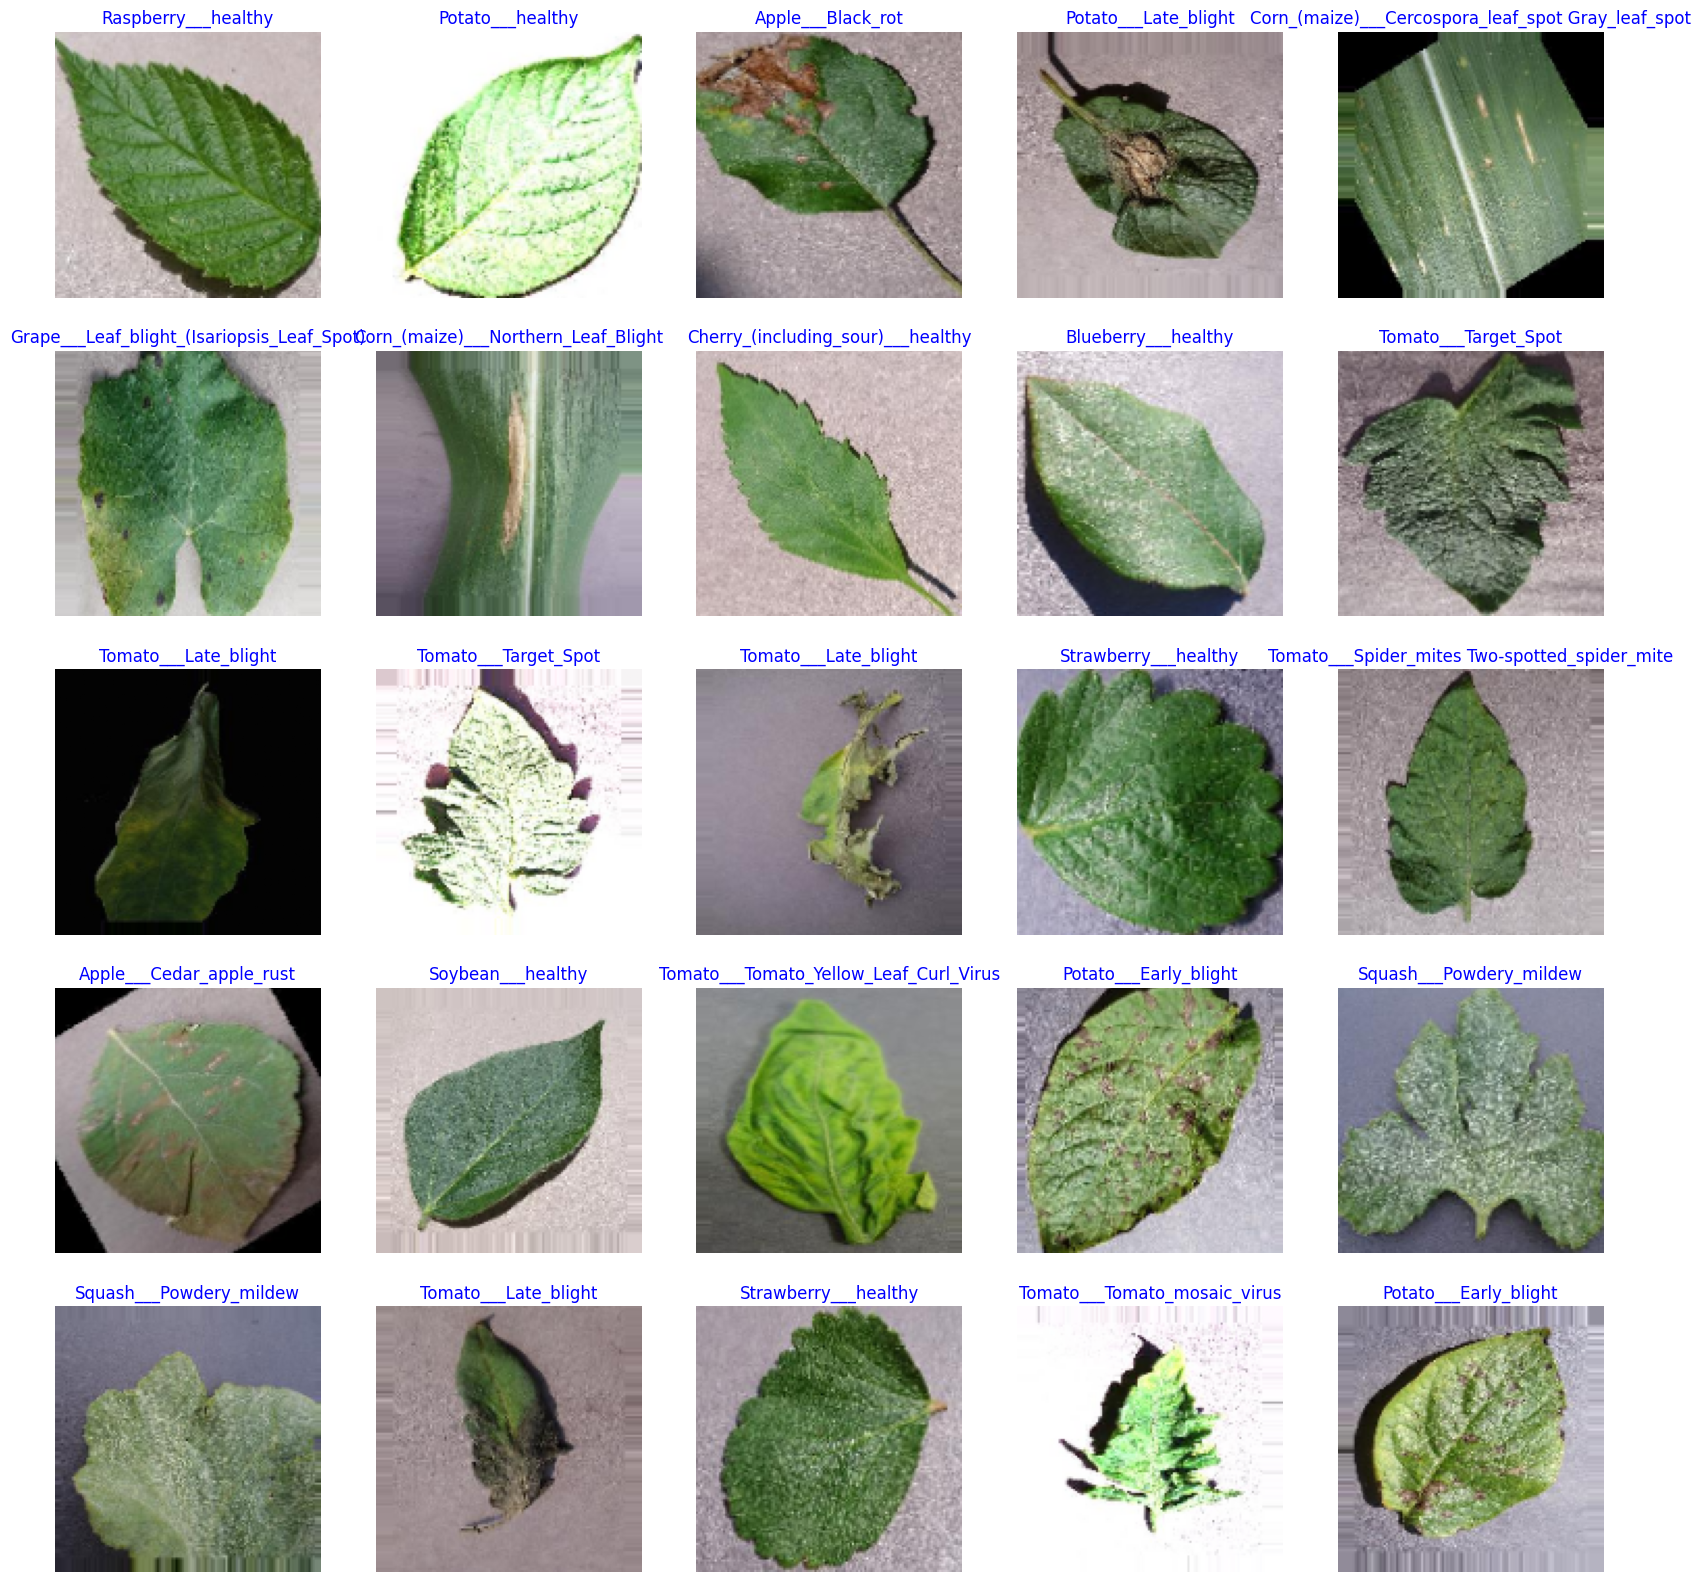

In [9]:
print("Images for Testing.......................")
show_image_samples(test_set)

### Convolutional Neural Network

    Basic CNN layers

In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2,)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.3))
model.add(Dense(38, activation='softmax'))

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model training

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [13]:
### Fitting data into our model

fitted_model = model.fit(training_set, steps_per_epoch=375, epochs=10, validation_data = test_set, validation_steps = 125)

Epoch 1/10
375/375 [==============================] - 291s 765ms/step - loss: 2.5351 - accuracy: 0.2909 - val_loss: 1.6362 - val_accuracy: 0.5052
Epoch 2/10
375/375 [==============================] - 257s 686ms/step - loss: 1.6289 - accuracy: 0.5110 - val_loss: 1.6743 - val_accuracy: 0.5217
Epoch 3/10
375/375 [==============================] - 229s 611ms/step - loss: 1.2847 - accuracy: 0.6049 - val_loss: 2.4563 - val_accuracy: 0.3938
Epoch 4/10
375/375 [==============================] - 209s 557ms/step - loss: 1.0733 - accuracy: 0.6619 - val_loss: 0.8789 - val_accuracy: 0.7222
Epoch 5/10
375/375 [==============================] - 197s 525ms/step - loss: 0.9240 - accuracy: 0.7081 - val_loss: 0.9082 - val_accuracy: 0.7175
Epoch 6/10
375/375 [==============================] - 376s 1s/step - loss: 0.7855 - accuracy: 0.7514 - val_loss: 0.5946 - val_accuracy: 0.8145
Epoch 7/10
375/375 [==============================] - 184s 491ms/step - loss: 0.7300 - accuracy: 0.7709 - val_loss: 0.9055 - va

In [15]:
fitted_model

### Convert the model into Pickle file

In [16]:
pickle.dump(fitted_model, open('Fitted_model.pkl', 'wb'))

In [ ]:
# pickle.dump(model, open('Leaf_disease_detection.pkl', 'wb'))

### Load the pickle file

In [ ]:
ldd_model = pickle.load(open('Leaf_disease_detection.pkl', 'rb'))

In [ ]:
ldd_model

In [ ]:
ldd_model.summary()

In [ ]:
labels = (training_set.class_indices)
labels2 = (test_set.class_indices)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=125)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

In [17]:
f_ldd_model = pickle.load(open('Fitted_model.pkl', 'rb'))

In [19]:
f_ldd_model.history

{'loss': [2.53511118888855,
  1.6289094686508179,
  1.284651756286621,
  1.07326078414917,
  0.9239519238471985,
  0.7855327129364014,
  0.7300200462341309,
  0.6731351613998413,
  0.620654284954071,
  0.5675807595252991],
 'accuracy': [0.2908848226070404,
  0.5109999775886536,
  0.6049166917800903,
  0.6619166731834412,
  0.7081144452095032,
  0.7514166831970215,
  0.7709166407585144,
  0.7880833148956299,
  0.8028333187103271,
  0.8188333511352539],
 'val_loss': [1.6362115144729614,
  1.674254059791565,
  2.4563212394714355,
  0.8788801431655884,
  0.908169686794281,
  0.5945681929588318,
  0.9055079817771912,
  0.5840756893157959,
  0.8781904578208923,
  0.5727118849754333],
 'val_accuracy': [0.5052499771118164,
  0.5217499732971191,
  0.39375001192092896,
  0.7222499847412109,
  0.7174999713897705,
  0.8144999742507935,
  0.7172499895095825,
  0.812749981880188,
  0.7335000038146973,
  0.8125]}

In [21]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=125)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

125/125 [==============================] - 32s 251ms/step - loss: 0.5836 - accuracy: 0.8105
Test loss: 0.5836107730865479
Test accuracy: 0.8105000257492065


In [35]:
model.save('trained_model.keras')

In [39]:
img1 = r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\images_for_test\CornCommonRust1.JPG'

test_image = image.load_img(img1, target_size=(128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

result1 = model.predict(test_image)

1/1 [==============================] - 0s 48ms/step


In [40]:
predicted_label = labels[result1.argmax()]
predicted_label

'_Apple_scab'

In [41]:
probability = np.max(result1)

probability

0.9492509

In [70]:
import streamlit as st
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import traceback
import warnings
warnings.filterwarnings('ignore')

class LeafDiseaseDetection:
    
    @staticmethod
    def testing(image_path):
        model_path = 'Leaf_disease_detection.pkl'
        
        try:
            with open(model_path, 'rb') as file:
                ldd_model = pickle.load(file)
        except Exception as e:
            st.error(f"Error loading the model: {e}")
            return None
            
        test_image = image.load_img(image_path, target_size=(128, 128))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        if ldd_model:
            result = ldd_model.predict(test_image)
        else:
            st.error("Model could not be loaded.")
            return None
        
        fresult = np.max(result)
        
        label = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
                 'Blueberry___healthy','Cherry_(including_sour)___healthy','Cherry_(including_sour)___Powdery_mildew',
                 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_',
                 'Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot',
                 'Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
                 'Orange___Haunglongbing_(Citrus_greening)','Peach___Bacterial_spot','Peach___healthy',
                 'Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight',
                 'Potato___healthy','Potato___Late_blight','Raspberry___healthy','Soybean___healthy',
                 'Squash___Powdery_mildew','Strawberry___healthy','Strawberry___Leaf_scorch',
                 'Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___healthy','Tomato___Late_blight',
                 'Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite',
                 'Tomato___Target_Spot','Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']
        
        label2 = label[result.argmax()]

        if result is not None:
            st.success(f"Your leaf disease is: {label2}")
        else:
            st.warning("Failed to get a prediction due to model loading issues.")

# Example usage
# LeafDiseaseDetection.testing("path_to_image.jpg")


In [73]:
LeafDiseaseDetection.testing(img1)

1/1 [==============================] - 0s 339ms/step


2024-08-02 16:09:59.673 
  command:

    streamlit run C:\Users\johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [72]:
test_image

array([[[[  3.,   3.,   3.],
         [  3.,   3.,   3.],
         [  3.,   3.,   3.],
         ...,
         [  3.,   3.,   5.],
         [  4.,   3.,   1.],
         [  6.,   2.,   0.]],

        [[  3.,   3.,   3.],
         [  3.,   3.,   3.],
         [  3.,   3.,   3.],
         ...,
         [  3.,   3.,   5.],
         [  4.,   3.,   1.],
         [  4.,   3.,   0.]],

        [[  3.,   3.,   3.],
         [  3.,   3.,   3.],
         [  3.,   3.,   3.],
         ...,
         [  3.,   3.,   5.],
         [  4.,   2.,   3.],
         [  4.,   3.,   0.]],

        ...,

        [[ 98.,  99.,  55.],
         [ 84.,  87.,  40.],
         [ 72.,  82.,  30.],
         ...,
         [  3.,   3.,   3.],
         [  3.,   3.,   3.],
         [  3.,   3.,   3.]],

        [[ 80.,  77.,  36.],
         [ 78.,  79.,  35.],
         [ 84.,  92.,  43.],
         ...,
         [  3.,   3.,   3.],
         [  3.,   3.,   3.],
         [  3.,   3.,   3.]],

        [[ 95.,  90.,  52.],
       

In [59]:
LeafDiseaseDetection.testing(test_image)

Error loading the model: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000020ABC4F8090>.


In [22]:
# Adjust the learning rate
initial_learning_rate = 1e-4
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]

In [ ]:
fitted_model1 = model.fit(training_set, steps_per_epoch=len(training_set), epochs=5, validation_data=test_set, validation_steps=len(test_set), callbacks=callbacks)

In [ ]:
tr_plot(fitted_model1, 0)

In [ ]:
# pickle.dump(model, open('Leaf_disease_detection_1.pkl', 'wb'))

In [ ]:
ldd_model1 = pickle.load(open('Leaf_disease_detection_1.pkl', 'rb'))

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

In [ ]:
label = os.listdir(train_dir) # your directory path

In [ ]:
len(label)

## Predicting Output

In [ ]:
#path=input("Enter your image path-: ")
def testing(path, ldd_model):
    
    test_image = image.load_img(path, target_size=(128,128))
    
    test_image = image.img_to_array(test_image)
    
    test_image = np.expand_dims(test_image, axis=0)
    
    result = ldd_model.predict(test_image)

    #print(f"Result is --> {result}")
    fresult = np.max(result)
    label2 = label[result.argmax()]
    
    print(f"your leaf disease is --> {label2}")

In [ ]:
img_path=r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\images_for_test\CornCommonRust1.JPG'

testing(img_path, ldd_model)

In [ ]:
## Sample Image

image.load_img(img_path, target_size=(128, 128))

In [ ]:
## Test image 2

img_path1 = r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\archive (3)\images_for_test\PotatoHealthy1.JPG'

testing(img_path1, ldd_model)

In [ ]:
# result.argmax()

In [ ]:
image.load_img(img_path1)

In [ ]:
img_path4 = r'C:\Users\johan\OneDrive\Desktop\DS Python\Tasks\NeubAltics\archive (3)\images_for_test\TomatoYellowCurlVirus4.JPG'

test_image = image.load_img(img_path4, target_size=(128,128))

test_image = image.img_to_array(test_image)

test_image = np.expand_dims(test_image, axis=0)

result = ldd_model.predict(test_image)

#print(f"Result is --> {result}")
fresult = np.max(result)
label2 = label[result.argmax()]

print(f"your leaf disease is --> {label2}")

In [23]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       1.4.0
aiohttp                       3.8.5
aiosignal                     1.3.1
alabaster                     0.7.16
altair                        5.0.1
altgraph                      0.17.3
anyio                         3.7.0
apsw                          3.44.0.0
argcomplete                   1.10.3
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asgiref                       3.7.2
asttokens                     2.2.1
astunparse                    1.6.3
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.2.0
Babel                         2.14.0
backcall                      0.2.0
bcrypt                        4.0.1
beautifulsoup4                4.12.3
bleach                        6.0.0
blinker                       1.6.2
blis                          0.7.9
bs4   

In [24]:

# Serialize model to JSON

model_json = model.to_json()

with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')    
print('Model saved to disk')

Model saved to disk


In [28]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights('model.h5')
print('Loaded model form disk')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'model.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [26]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [29]:
# Serialize model to JSON

model_json = model.to_json()

with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.keras')    
print('Model saved to disk')

Model saved to disk


In [30]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights('model.keras')
print('Loaded model form disk')

Loaded model form disk


In [32]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [27]:
try:
    model1 = load_model('model.h5')
    print(model1)
except FileNotFoundError:
    print("Model file not found.")
    print(None)
except Exception as e:
    print(f"Error loading the model: {e}")
    print(None)

Error loading the model: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000020AB6C09390>.
None


In [ ]:
model.summary()

In [ ]:
ldd_model1.summary()